# Восстановление золота из руды

Подготовка прототипа модели машинного обучения для компании "Цифра". Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды по данным с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Ход исследования:**
* Подготовка данных:
  * Выгрузка файлов;
  * Проверка эффективности обогащения;
  * Анализ признаков, недоступных в тестовом наборе данных;
  * Предобработка данных;
* Анализ данных:
  * Исследование изменения концентрации металлов на разных этапах очистки;
  * Сравнение распределений на обучающей и тестовой выборках;
  * Исследование суммарной концентрации всех веществ на разных стадиях;
* Обучение модели;
* Тестирование модели;
* Итоги исследования.

## Подготовка данных

In [1]:
!pip install sweetviz -q

In [2]:
# подключение библиотек

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

### Выгрузка и изучение данных

Прочитаем данные из файлов:

In [3]:
# исходные данные
df = pd.read_csv("gold_recovery_full_new.csv")
# обучающая выборка
df_train = pd.read_csv("gold_recovery_train_new.csv")
# тестовая выборка
df_test = pd.read_csv("gold_recovery_test_new.csv")

Для начала изучим исходную таблицу, содержащую все имеющиеся данные, включая обучающую и тестовую выборки. 

In [6]:
report1 = sv.analyze([df, "Исходные данные"])
report1.show_html(filepath='SWEETVIZ_REPORT1.html', scale=1.0)

                                             |                                             | [  0%]   00:00 ->…

Report SWEETVIZ_REPORT1.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Полученный отчет можно посмотреть в папке проекта: `"SWEETVIZ_REPORT1.html"`

Итак, сделаем выводы по полученному отчету об исходном датафрейме:

* В исходной таблице 19439 объектов и 87 признаков. 

* 86 признаков являются числовыми, и только один - `date` текстовым.

* В датафрейме нет строк-дубликатов. 

* В столбце `date` все объекты уникальные.

* Во многих столбцах таблицы есть пропуски, но во всех случаях их количество не превышает 2% от всего объема данных, и только в одном столбце (`secondary_cleaner.output.tail.sol`) число пропусков составляет 9%. 

Теперь рассмотрим обучающую и тестовые выборки. Для них создадим один сравнительный отчет.

In [7]:
report2 = sv.compare([df_train, 'Обучающая выборка'], [df_test, 'Тестовая выборка'])
report2.show_html(filepath='SWEETVIZ_REPORT2.html', scale=1.0)

                                             |                                             | [  0%]   00:00 ->…

Report SWEETVIZ_REPORT2.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Полученный отчет можно посмотреть в папке проекта: `"SWEETVIZ_REPORT2.html"`

Выводы о тестовой и обучающей выборках:

* Похоже, что обучающая и тестовая выборки и правда были взяты из исходного датафрейма.

* В обучающей выборке сохранились все 87 признаков из исходного датафрейма, а вот в тестовой их только 53. Это связано с тем, что некоторые параметры замеряются и/или рассчитываются значительно позже, а также в тестовом наборе нет всех целевых признаков с началом `final` в названии признаков (всего таких признаков 9). 


### Проверка эффективности обогащения

Проверим, что эффективность обогащения рассчитана правильно. Создадим функцию для ее вычисления на обучающей выборке для признака `rougher.output.recovery` и найдем MAE между проведенными расчетами и значениями признака. 

Эффективность обогащения рассчитывается по формуле:

$$
    Recovery = \frac{C * (F - T)}{F * (C - T)}\
$$

где: 

* `C` — доля золота в концентрате после флотации/очистки;

* `F` — доля золота в сырье/концентрате до флотации/очистки;

* `T` — доля золота в отвальных хвостах после флотации/очистки.


In [8]:
# функция проверки эффективности обогащения

# c - 'rougher.output.concentrate_au'
# f - 'rougher.input.feed_au'
# t - 'rougher.output.tail_au'

def check_recovery(c, f, t):
    recovery = ((c * (f - t)) / (f * (c - t))) * 100
    return recovery

Используем функцию на обучающих данных:

In [9]:
# создание нового столбца с расчетами для последующего сравнения 

df_train['rougher.output.check_recovery'] = check_recovery(df_train['rougher.output.concentrate_au'], 
                                                          df_train['rougher.input.feed_au'], 
                                                          df_train['rougher.output.tail_au'])

df_train[['rougher.output.recovery', 'rougher.output.check_recovery']].head()

,rougher.output.recovery,rougher.output.check_recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


На первый взгляд эффективность расчитана правильно. Проверим значение MAE для этих двух признаков:

In [10]:
mean_absolute_error(df_train['rougher.output.recovery'], df_train['rougher.output.check_recovery'])

9.73512347450521e-15

Значение ошибки довольно низкое, следовательно эффективность обогащения в тестовой выборке рассчитана верно. 

### Анализ признаков, недоступных в тестовом наборе данных

Внимательнее посмотрим, какие признаки обучающей выборки отсутствуют в тестовом наборе. 

In [11]:
df_train.drop(df_test.columns, axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 35 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                                14149 non-null  float64


В тестовом наборе данных отсутствуют выходные параметры (`output`) продукта на разных этапах процесса восстановления золота из руды. 

### Предобработка данных

Сперва удалим из обучающей выборки все признаки, которых нет в тестовой. Обучение модели должно проходить только на тех признаках, которые в дальнейшем изначально будут в распоряжении. 

In [12]:
# Сохранение в обучающей выборке только тех признаков, которые будут доступны в продакшене

df_train = df_train[df_test.columns]

Следующей замеченной проблемой были многочисленные пропуски, встречающиеся в большинстве признаков  в обеих выборках. 

In [13]:
# проверка наличия пропусков в обучающем наборе данных

df_train.isna().sum().sort_values(ascending=False).head(10)

rougher.state.floatbank10_e_air             436
rougher.input.floatbank11_xanthate          428
secondary_cleaner.state.floatbank2_a_air    217
rougher.input.feed_size                     144
rougher.input.feed_pb                       100
primary_cleaner.input.xanthate              100
rougher.input.feed_sol                       78
rougher.input.floatbank11_sulfate            36
primary_cleaner.input.depressant             32
rougher.input.floatbank10_sulfate            29
dtype: int64

In [14]:
df_train.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


От пропусков нужно избавиться, так как они помешают при обучении моделей. Обратим внимание на столбец `date`: отчет выше показал, что все значения в этом столбце - уникальные, и также можно заметить, что объекты в таблице упорядочены по времени. Тогда заполнение пропусков можно провести основываясь именно на этом факте и заменить пропущенные значения ближайшими к ним значениями, то есть предыдущими по времени. 

Но перед этим стоит проверить все периоды между зафиксированными значениями времени на случай, если среди них есть особенно длительные.

In [15]:
# перевод date в формат datetime

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')

In [16]:
df_timedelta = pd.DataFrame(df['date'].diff())
df_timedelta.value_counts()

date           
0 days 01:00:00    19017
0 days 02:00:00      191
0 days 03:00:00       59
0 days 04:00:00       33
0 days 05:00:00       24
0 days 06:00:00       18
0 days 08:00:00       12
0 days 07:00:00       11
0 days 09:00:00        8
0 days 12:00:00        7
0 days 10:00:00        6
0 days 15:00:00        5
0 days 13:00:00        4
0 days 14:00:00        4
0 days 11:00:00        3
1 days 08:00:00        3
0 days 20:00:00        2
0 days 21:00:00        2
1 days 02:00:00        2
0 days 19:00:00        2
0 days 18:00:00        2
3 days 06:00:00        1
6 days 19:00:00        1
6 days 15:00:00        1
6 days 12:00:00        1
5 days 14:00:00        1
5 days 13:00:00        1
5 days 04:00:00        1
4 days 13:00:00        1
4 days 03:00:00        1
3 days 13:00:00        1
3 days 07:00:00        1
2 days 12:00:00        1
2 days 00:00:00        1
1 days 23:00:00        1
1 days 14:00:00        1
1 days 10:00:00        1
0 days 06:59:59        1
1 days 05:00:00        1
1 days 04

Большинство наблюдений сделаны с разницей во времени в один час, однако есть единичные примеры, где период пропуска превышает один день и доходит даже до восьми дней.

In [17]:
# Замена пропусков в обучающей и тестовой выборках

df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')

Итак, пропуски в выборках, с которыми будет продолжаться работа, устранены. Значения столбца `date` сделаем индексами во всех таблицах.

In [18]:
# превращение столбца `date` в индексовый для всех датафреймов

df, df_train, df_test = df.set_index(['date']), df_train.set_index(['date']), df_test.set_index(['date'])

**Выводы**

Важные наблюдения и внесенные изменения на этапе подготовки данных:

* Проверка целевого признака `rougher.output.recovery` прошла успешно: значение MAE оказалось очень низким.

* Из обучающей выборки были удалены все признаки, отсутвующие в тестовой выборке.

* Все пропуски в обеих выборках заполнены ближайшими к ним по времени значениями. 

* Столбец `date` приведен к формату даты и назначен индексовым во всех трех датафреймах.

Данные готовы к их дальнейшему анализу и обучению на них моделей. 

## Анализ данных

### Исследование признаков на разных этапах очистки

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Для этого построим графики. 

In [19]:
# функция отрисовки графика

def concentrate(roughter, primary_cleaner, final, main_title):
    plt.figure(figsize=(10, 7))
    sns.distplot(df[roughter], bins=30, label='roughter')
    sns.distplot(df[primary_cleaner], bins=30, label='primary_cleaner')
    sns.distplot(df[final], bins=30, label='final')
    plt.grid(visible=True)
    plt.legend(title='Этапы очистки')
    plt.title(main_title) 

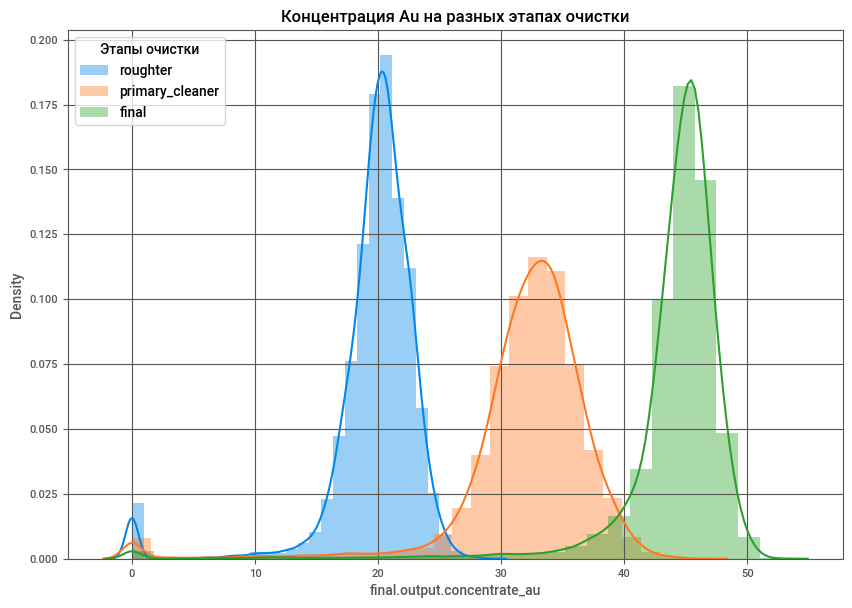

In [20]:
# Исследование концентрации Au

concentrate('rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 
            'final.output.concentrate_au', 'Концентрация Au на разных этапах очистки')

Высокая концентрация `Au` на этапе флотации снижается после первичной очистки, а на финальном этапе показывает более высокий результат. Значения слева на этом и последующих графиках являются выбросами.

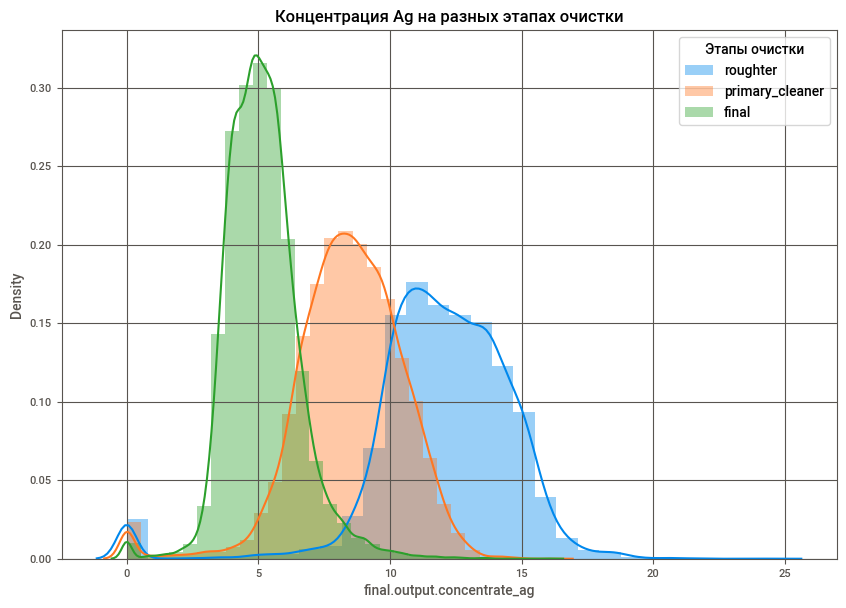

In [21]:
# Исследование концентрации Ag

concentrate('rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 
            'final.output.concentrate_ag', 'Концентрация Ag на разных этапах очистки')

С каждым последующим этапом концентрация `Au` снижается, а распределение становится шире.

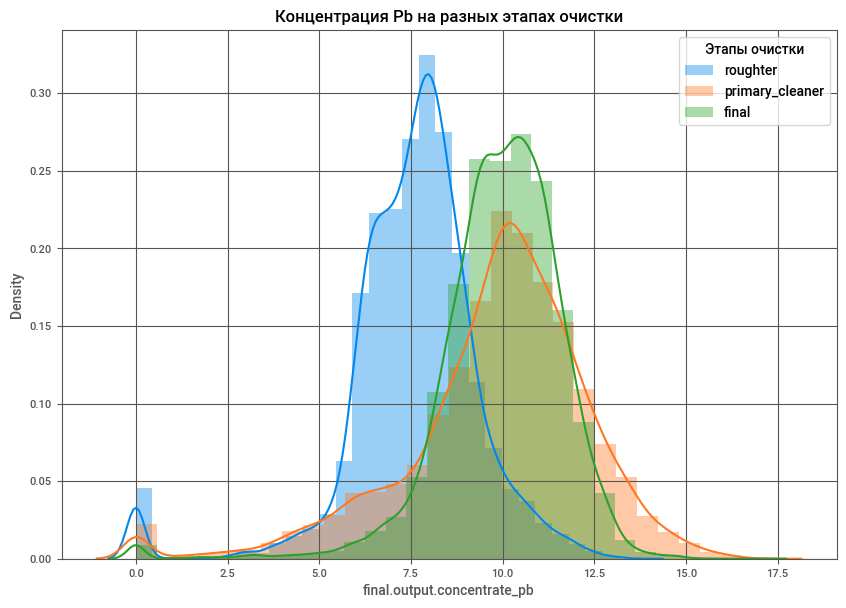

In [22]:
# Исследование концентрации Pb

concentrate('rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 
            'final.output.concentrate_pb', 'Концентрация Pb на разных этапах очистки')

Что касается `Pb`, здесь концентрация немного увеличивается после этапа первичной обпаботки.

**Выводы**

* К финальному этапу концентрация золота значительно увеличивается;
* Концентрация серебра к финальному этапу очистки постепенно снижается;
* Концентрация свинца немного возрастает на финальном этапе очистки.

### Сравнение распределений на обучающей и тестовой выборках

Теперь сравним распределения размеров гранул сырья на обучающей и тестовой выборках. В том случае, если распределения будут сильно отличаться, деление данных на выборки было произведено некорректно и при таких выборках будет большой риск того, что оценка модели будет неправильной. 

Так как в обеих выборках у этого признака присутствуют аномальные значения, стоит удалить их с графика, чтобы лучше увидеть основное распределение. 

(0.0, 200.0)

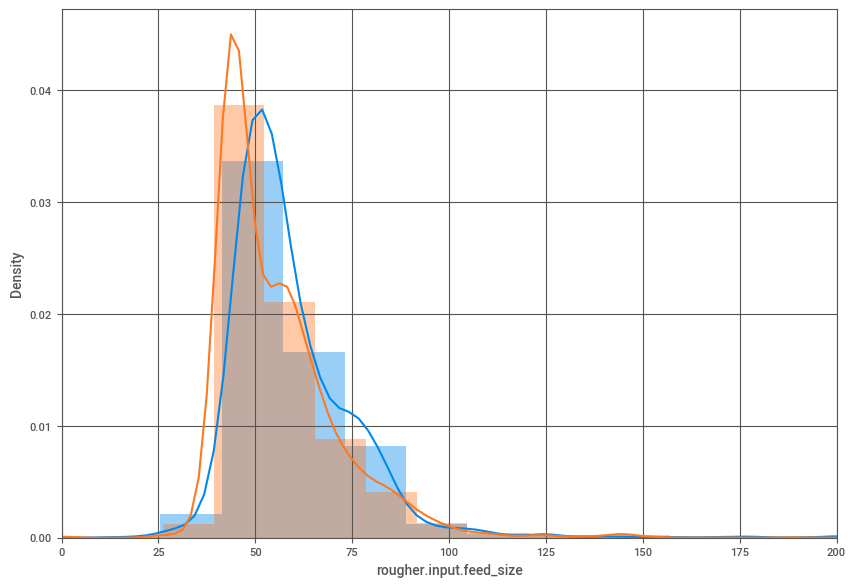

In [23]:
# rougher.input.feed_size 

plt.figure(figsize=(10, 7))
sns.distplot(df_train['rougher.input.feed_size'], bins=30)
sns.distplot(df_test['rougher.input.feed_size'], bins=30)
plt.grid(visible=True)
plt.xlim(left=0, right=200)

В целом, распределения в обучающей и тестовой выборках довольно похожи, так что проводить проводить дополнительную работу по образованию лучших выборок не нужно. Будем обучать модели на них. 

### Исследование суммарной концентрации всех веществ на разных стадиях

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Для этого сначала сложим все концентрации.

In [24]:
# функция сложения всех концентраций

def sum_concentrate(ag, pb, sol, au):
    return df[ag] + df[pb] + df[sol] + df[au]

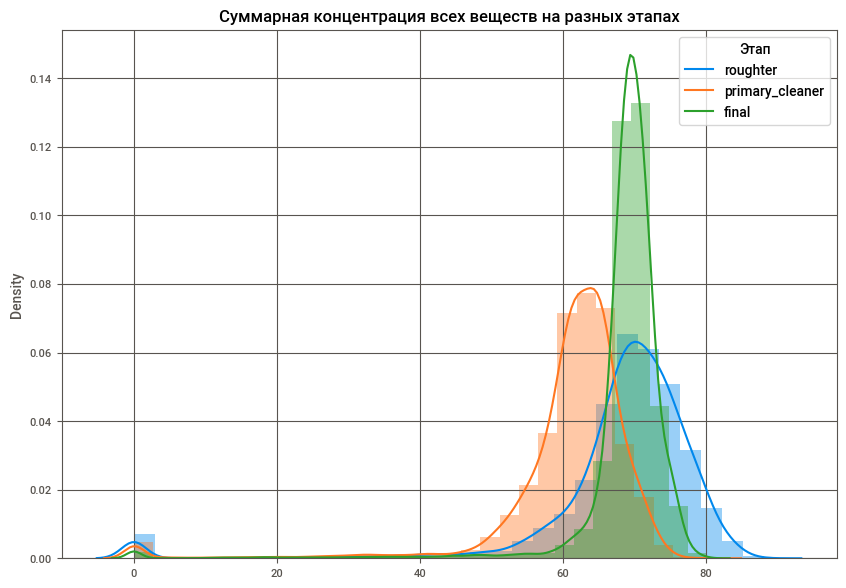

In [25]:
# расчет суммарных концентраций
roughter_sum = sum_concentrate('rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 
                            'rougher.output.concentrate_sol', 'rougher.output.concentrate_au')

primary_cleaner_sum = sum_concentrate('primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb',
                            'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au')

final_sum = sum_concentrate('final.output.concentrate_ag', 'final.output.concentrate_pb', 
                           'final.output.concentrate_sol', 'final.output.concentrate_au')

# Отрисовка графика
plt.figure(figsize=(10, 7))
sns.distplot(roughter_sum, bins=30)
sns.distplot(primary_cleaner_sum, bins=30)
sns.distplot(final_sum, bins=30)
plt.grid(visible=True)
plt.title('Суммарная концентрация всех веществ на разных этапах')
plt.legend(['roughter', 'primary_cleaner', 'final'], title='Этап')

Нулевые и отрицательные значения, наблюдающиеся на графике являются аномальными: суммарная концентрация всех веществ не может равняться нулю ни на одном из этапов. Значит измерения с нулевой суммарной концентрацией, скорее всего, являются какими-то сбоями в сборе данных. Стоит удалить эти данные из обучающей и тестовой выборок. 

In [26]:
def drop_zeros(df):
    df = df.drop(roughter_sum[roughter_sum <= 0].index, errors='ignore')
    df = df.drop(primary_cleaner_sum[primary_cleaner_sum <= 0].index, errors='ignore')
    df = df.drop(final_sum[final_sum <= 0].index, errors='ignore')
    return df

In [27]:
print(f'Размер обучающей выборки: {df_train.shape[0]}\nРазмер тестовой выборки: {df_test.shape[0]}')

df_train = drop_zeros(df_train)
df_test = drop_zeros(df_test)

print(f'\nРазмер обучающей выборки после удаления нулей: {df_train.shape[0]}\nРазмер тестовой выборки: {df_test.shape[0]}')

Размер обучающей выборки: 14149
Размер тестовой выборки: 5290

Размер обучающей выборки после удаления нулей: 13725
Размер тестовой выборки: 5123


Мусорные значения удалены из выборок, теперь можно начинать обучение моделей.

## Модель

Для начала введем метрику, с помощью которой будет оцениваться качество предсказаний моделей машинного обучения. Этой метрикой будет **sMAPE** (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»). Так как спрогнозировать нужно сразу две величины:
* эффективность обогащения чернового концентрата `rougher.output.recovery`;

* эффективность обогащения финального концентрата `final.output.recovery`,

итоговая метрика будет складываться из двух величин. Создадим функции для расчета отдельных метрик и итоговой **sMAPE**.

In [28]:
# Функция расчета sMAPE для одного целевого признака

def smape(target, predictions):
    result = ((1 / len(target)) * (abs(target - predictions) / ((abs(target) + abs(predictions)) / 2))).sum() * 100
    return result

In [29]:
# функция расчета итоговой sMAPE

def total_smape(roughter_smape, final_smape):
    result = 0.25 * roughter_smape + 0.75 * final_smape
    return result

Теперь к имеющимся тренировочной и тестовой выборкам нужно дабавить целевые признаки, но так как их у нас сразу два, для каждого из них стоит сделать отдельные тренировочные и тестовые выборки. 

In [30]:
# создание выборок для чернового концентрата roughter

columns_roughter = ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 
                    'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au', 
                    'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 
                    'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 
                    'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 
                    'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 
                    'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 
                    'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level', 
                    'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level', 
                    'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level' 
                   ]

roughter_train_ft = df_train[columns_roughter]
roughter_train_tg = df['rougher.output.recovery'][roughter_train_ft.index]
roughter_test_ft = df_test[columns_roughter]
roughter_test_tg = df['rougher.output.recovery'][roughter_test_ft.index]

print(f'Размеры тренировочной выборки: {roughter_train_ft.shape}, {roughter_train_tg.shape}')
print(f'Размеры тестовой выборки: {roughter_test_ft.shape}, {roughter_test_tg.shape}')

Размеры тренировочной выборки: (13725, 22), (13725,)
Размеры тестовой выборки: (5123, 22), (5123,)


In [31]:
# создание выборок для финального концентрата final

final_train_ft = df_train.drop(columns_roughter, axis=1)
final_train_tg = df['final.output.recovery'][final_train_ft.index]
final_test_ft = df_test.drop(columns_roughter, axis=1)
final_test_tg = df['final.output.recovery'][final_test_ft.index]

print(f'Размеры тренировочной выборки: {final_train_ft.shape}, {final_train_tg.shape}')
print(f'Размеры тестовой выборки: {final_test_ft.shape}, {final_test_tg.shape}')

Размеры тренировочной выборки: (13725, 30), (13725,)
Размеры тестовой выборки: (5123, 30), (5123,)


In [32]:
final_test_tg

date
2016-09-01 00:59:59    70.273583
2016-09-01 01:59:59    68.910432
2016-09-01 02:59:59    68.143213
2016-09-01 03:59:59    67.776393
2016-09-01 04:59:59    61.467078
                         ...    
2017-12-31 19:59:59    68.919891
2017-12-31 20:59:59    68.440582
2017-12-31 21:59:59    67.092759
2017-12-31 22:59:59    68.061186
2017-12-31 23:59:59    71.699976
Name: final.output.recovery, Length: 5123, dtype: float64

Теперь приступим к обучению моделей. Будем тестировать три модели:
* Решающее дерево;
* Случайный лес;
* Линейную регрессию

Для обучения и оценки качества моделей будем использовать кроссс-валидацию `GridSearchCV`.

In [33]:
# функция обучения и подбора гиперпараметров с помощью кросс-валидации 

def cross_valid(model, params, ft, tg):
    scorer = make_scorer(smape, greater_is_better=False)
    clf = GridSearchCV(model, params, scoring=scorer, cv=5, verbose=False)
    clf.fit(ft, tg)
    
    return clf.best_estimator_, clf.best_score_

In [34]:
# функция поиска трех наилучших моделей для определенного целевого признака

def search_best_model(train_ft, train_tg):
    
    print('Лучшая модель решающего дерева:')
    model_tree = RandomForestRegressor(random_state=12345)
    params = {'max_depth': range(1, 11)}
    best_tree_model, best_tree_result = cross_valid(model_tree, params, train_ft, train_tg)
    print(f'sMAPE: {best_tree_result}')
    
    print('\nЛучшая модель случайного леса:')
    model_forest = RandomForestRegressor(random_state=12345)
    params = {'n_estimators': range(1, 101, 10),
             'max_depth': range(1, 11)}
    best_forest_model, best_forest_result = cross_valid(model_forest, params, train_ft, train_tg)
    print(f'sMAPE: {best_forest_result}')
    
    print('\nЛучшая модель линейной регрессии:')
    model_linreg = LinearRegression()
    params = {}
    best_linreg_model, best_linreg_result = cross_valid(model_linreg, params, train_ft, train_tg)
    print(f'sMAPE: {best_linreg_result}')
    
    results = [best_tree_result, best_forest_result, best_linreg_result]
    
    return best_tree_model, best_forest_model, best_linreg_model, results

Используем функцию и обучим модели на данных, где в роли целевого признака выступает черновой концентрат roughter:

In [35]:
# roughter
best_tree_model_r, best_forest_model_r, best_linreg_model_r, results_r = search_best_model(roughter_train_ft, 
                                                                                           roughter_train_tg)

Лучшая модель решающего дерева:
sMAPE: -6.612516258378477

Лучшая модель случайного леса:
sMAPE: -6.587458806993871

Лучшая модель линейной регрессии:
sMAPE: -6.677118661212717


И теперь используем функцию на выборках для финального концентрата:

In [36]:
# final
best_tree_model_f, best_forest_model_f, best_linreg_model_f, results_f = search_best_model(final_train_ft, 
                                                                                          final_train_tg)

Лучшая модель решающего дерева:
sMAPE: -9.970436485179524

Лучшая модель случайного леса:
sMAPE: -9.975258464416754

Лучшая модель линейной регрессии:
sMAPE: -9.743932629320524


По полученным результатам вычислим итоговую sMAPE. Все полученные значения метрики:

In [37]:
# таблица с результатами

columns_results = {'sMAPE roughter': results_r, 
              'sMAPE final': results_f, 
              'sMAPE total': [total_smape(results_r[0], results_f[0]), 
                             total_smape(results_r[1], results_f[1]),
                             total_smape(results_r[2], results_f[2])]}

all_results = pd.DataFrame(data=columns_results, index=('Решающее дерево', 'Случайный лес', 'Линейная регрессия'))
all_results

,sMAPE roughter,sMAPE final,sMAPE total
Решающее дерево,-6.612516,-9.970436,-9.130956
Случайный лес,-6.587459,-9.975258,-9.128309
Линейная регрессия,-6.677119,-9.743933,-8.977229


**Выводы:**

Лучшие результаты показала **модель случайного леса**. Ее отдельные и итоговое значения метрики sMAPE оказались наименьшими. Перейдем на этап тестирования. 

## Тестирование модели

Осталось только проверить нашу модель на тестовой выборке. 

In [38]:
def test_model(best_model, test_ft, test_tg, train_ft, train_tg):
    # тестирование лучшей модели на тестовой выборке
    test_predictions = best_model.predict(test_ft)
    best_model_result = smape(test_tg, test_predictions)

    # проверка на адекватность: определение sMAPE константной моделью
    constant_model = DummyRegressor(strategy='median').fit(train_ft, train_tg)
    constant_predictions = constant_model.predict(test_ft)
    const_result = smape(test_tg, constant_predictions)
    
    return [best_model_result, const_result]

In [39]:
roughter_smape = test_model(best_forest_model_r, roughter_test_ft, roughter_test_tg, roughter_train_ft, roughter_train_tg)
final_smape = test_model(best_forest_model_f, final_test_ft, final_test_tg, final_train_ft, final_train_tg)

columns_results = {'sMAPE roughter': roughter_smape, 
                  'sMAPE final': final_smape, 
                   'sMAPE total': [total_smape(roughter_smape[0], final_smape[0]), 
                                  total_smape(roughter_smape[1], final_smape[1])]}

results = pd.DataFrame(data=columns_results, index=['Случайный лес', 'Константная модель'])
results

,sMAPE roughter,sMAPE final,sMAPE total
Случайный лес,4.678503,7.664344,6.917884
Константная модель,4.809033,8.222545,7.369167


Значение метрики sMAPE обученной модели случайного леса на тестовой выборке оказалось ненамного, но ниже sMAPE константной модели. Можно считать, что наша модель прошла проверку на вменяемость. 

## Общий вывод

Итак, подведем итоги проделанной работы:

1. В результате проверки данных установили, что данные корретны и эффективность обогащения рассчитана верно. 
2. В обучающей выборке были сохранены только те признаки, данные которых известны изначально.
3. Все данные прошли через продобработку: все пропуски были заполнены. 
4. На этапе анализа данных проверили, что обучающая и тестовая выборки были корректно извлечены из общего датасета
5. Удалены аномальные нулевые значения в концентрации веществ
6. Выделены два целевых признака и для каждого из них рассмотрены по три разных моели обучения. В обоих случая лучшие результаты показала модель **случайного леса**
7. Выбранная лучшая модель прошла проверку на тестовой выборке и показала хорошие результаты в сравнении с константной моделью. 

Итак, конечные результаты выбранной модели:
* На обучающей выборке итоговый sMAPE: `-9.12`

* На тестовой выборке итоговый sMAPE: `6.91`